In [1]:
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from openml import datasets, tasks, flows, config
from openmlstudy14.preprocessing import ConditionalImputer
from workloadoptimization.essentials import Component, ExperimentParser
from workloadoptimization.hyperopt_helper import TrialConverter
from workloadoptimization.openml_helper import OpenMLReader
from workloadoptimization.search_space import SearchSpaceDesigner
%matplotlib inline

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)

config.apikey = '8e2079508005379adb9a60798696134e'
config.server = 'https://www.openml.org/api/v1'
config.set_cache_directory(os.path.expanduser('~/openml-cache'))

In [3]:
# Constants 
LOGISTIC_REGRESSION_FLOW = 5981
RANDOM_FOREST_FLOW = 8568
CREDIT_G_DATASET = 31

In [4]:
def extract_experiments(file_path, task_ids, flow_ids):
    openMLReader = OpenMLReader()
    if os.path.isfile(file_path):
        return pd.read_pickle(file_path)
    frames = []
    for t in task_ids:
        for f in flow_ids:
            frames.append(openMLReader.getTopRuns(-1, f, t))
    experiments = pd.concat(frames).reset_index(drop=True)
    experiments.to_pickle(file_path)
    return experiments


# This is time consuming, so it is better to persist the list of the runs to disk
# If you are changing the tasks or flow ids, remember to change the name of the file 
Experiments = extract_experiments('meta/database-experiment-warmstarting-openml', [CREDIT_G_DATASET], 
                                  [LOGISTIC_REGRESSION_FLOW, RANDOM_FOREST_FLOW])

## Loading the Pipelines, Experiment Objects, and the Dataset

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([('dualimputer', ConditionalImputer()),
                        ('standardscaler', StandardScaler()),
                        ('logisticregression', LogisticRegression())])

In [10]:
# The openml api is not backward compatible for this specific pipeline (5981), so we are recreating it in scikit learn
OPENML_FLOWS = {LOGISTIC_REGRESSION_FLOW: pipeline_lr}
parser = ExperimentParser()
experimentObjects = parser.extract_sklearn_pipelines(Experiments[Experiments.flow_id == LOGISTIC_REGRESSION_FLOW]
                                                     , OPENML_FLOWS)
OPENML_FLOWS = {RANDOM_FOREST_FLOW: flows.get_flow(RANDOM_FOREST_FLOW)}
experimentObjects = experimentObjects + parser.extract_openml_flows(
    Experiments[Experiments.flow_id == RANDOM_FOREST_FLOW]
    , OPENML_FLOWS)


In [2]:
# load the dataset
task = tasks.get_task(task_id=CREDIT_G_DATASET)
dataset = datasets.get_dataset(dataset_id=task.dataset_id)
data = dataset.get_data()
train_indices, test_indices = task.get_train_test_split_indices()
X, y, attribute_names = dataset.get_data(
    target=dataset.default_target_attribute,
    return_attribute_names=True)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

NameError: name 'CREDIT_G_DATASET' is not defined

## Define the Objective Function

In [15]:
def objective(pipeline, params):
    print '.',
    pipeline.set_params(**params)
    pipeline.fit(X_train, y_train)
    accuracy = pipeline.score(X_test, y_test)
    return 1 - accuracy

## Experiment for the Logistic Regression Model

In [16]:
# Check parameter space, for the logistic regression there's only one unique set of configurations
for k in experimentObjects[0].extractParams().keys():
    if not k.startswith('logisticregression'):
        a = []
        for e in experimentObjects:
            if e.flow == LOGISTIC_REGRESSION_FLOW:
                a.append(e.extractParams()[k])
        print(k, [[x, a.count(x)] for x in set(a)])


('standardscaler__with_mean', [[True, 11]])
('standardscaler__copy', [[True, 11]])
('standardscaler__with_std', [[True, 11]])


In [17]:
import copy
import warnings

warnings.filterwarnings('ignore')
baseline = []
iter_baseline = []
pipeline = Pipeline([('dualimputer', ConditionalImputer()),
                     ('standardscaler', StandardScaler()),
                     ('logisticregression', LogisticRegression())])
# Baseline 
for e in experimentObjects:
    if e.flow == LOGISTIC_REGRESSION_FLOW:
        start = time.time()
        params = e.extractParams()
        params['logisticregression__tol'] = 1e-16
        params['logisticregression__warm_start'] = False
        params['logisticregression__solver'] = 'saga'
        params['logisticregression__dual'] = False
        params['logisticregression__max_iter'] = 10000
        quality = objective(pipeline, params)
        end = time.time()
        time_to_converge_baseline = end - start
        baseline.append(time_to_converge_baseline)
        iter_baseline.append(pipeline.steps[2][1].n_iter_[0])
# Optimized
# reinitialize the pipeline (model parameters)
pipeline = Pipeline([('dualimputer', ConditionalImputer()),
                     ('standardscaler', StandardScaler()),
                     ('logisticregression', LogisticRegression())])
optimized = []
iter_optimized = []
best_pipeline = copy.deepcopy(pipeline)
best_quality = 0.0
for e in experimentObjects:
    if e.flow == LOGISTIC_REGRESSION_MODEL:
        start = time.time()
        params = e.extractParams()
        params['logisticregression__tol'] = 1e-16
        params['logisticregression__warm_start'] = True
        params['logisticregression__solver'] = 'saga'
        params['logisticregression__dual'] = False
        params['logisticregression__max_iter'] = 10000
        # warm start the model to the best existing model
        pipeline = copy.deepcopy(best_pipeline)
        quality = objective(pipeline, params)
        # print params['logisticregression__max_iter'], pipeline.steps[2][1].n_iter_
        end = time.time()
        time_to_converge = end - start
        optimized.append(time_to_converge)
        iter_optimized.append(pipeline.steps[2][1].n_iter_[0])
        # if the quality of the new model is better existing best model
        # replace the best model with the existing model
        if quality > best_quality:
            print ('changing the best model %', quality) 
            best_quality = quality
            best_pipeline = copy.deepcopy(pipeline)


.

 .

 . .

 . .

 .

 . .

 . .

 .

 ('changing the best model %', 0.30000000000000004)
.

 .

 . .

 . .

 .

 .

 . .

In [18]:
import numpy
result = pd.DataFrame.from_dict({'method': ['warmstart', 'baseline'],
                                 'time': [numpy.sum(optimized), numpy.sum(baseline)],
                                 'num_iterations': [numpy.sum(iter_optimized)/1000, numpy.sum(iter_baseline)/1000]})


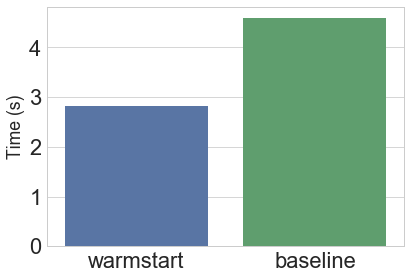

In [19]:
ax = sns.barplot(x='method', y='time', data=result)
ax.set_xlabel('')
ax.set_ylabel('Time (s)')
ax.tick_params(labelsize=22)
# ax.set_title('Pipeline 5981 (LogisticRegression with SGD)\n11 Executions')
plt.savefig('figures/paper/warmstarting-lr-5981-runtime.eps', format='eps', dpi=1000, bbox_inches='tight')

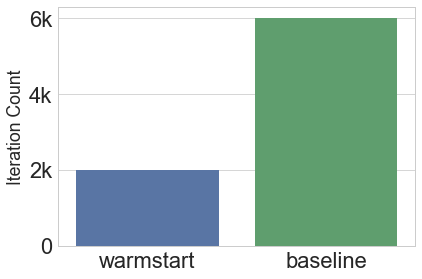

In [20]:
ax = sns.barplot(x='method', y='num_iterations', data=result)
ax.set_xlabel('')
ax.set_ylabel('Iteration Count')
ax.set_yticklabels(['0', '2k', '4k', '6k'])
ax.tick_params(labelsize=22)
# ax.set_title('Pipeline 5981 (LogisticRegression with SGD)\n11 Executions')
plt.savefig('figures/paper/warmstarting-lr-5981-iterations.eps', format='eps', dpi=1000, bbox_inches='tight')

## Experiment for Random Forest Model

In [21]:
for k in experimentObjects[11].extractParams().keys():
    if k != 'onehotencoder__categorical_features' and k != 'conditionalimputer__categorical_features' and not k.startswith('randomforestclassifier'):
        a = []
        for e in experimentObjects:
            if e.flow == RANDOM_FOREST_FLOW:
                a.append(e.extractParams()[k])
        print(k, [[x, a.count(x)] for x in set(a)])


('onehotencoder__n_values', [['auto', 555]])
('conditionalimputer__verbose', [[0, 555]])
('conditionalimputer__strategy', [['most_frequent', 136], ['median', 163], ['mean', 256]])
('onehotencoder__dtype', [[<type 'numpy.float64'>, 555]])
('variancethreshold__threshold', [[0.0, 555]])
('onehotencoder__sparse', [[False, 201], [True, 354]])
('onehotencoder__handle_unknown', [['ignore', 555]])
('conditionalimputer__missing_values', [['NaN', 555]])
('conditionalimputer__fill_empty', [[0, 555]])
('conditionalimputer__copy', [[True, 555]])
('conditionalimputer__axis', [[0, 555]])
('conditionalimputer__strategy_nominal', [['most_frequent', 555]])


In [22]:
unique_pipelines = {}
# conditionalimputer__strategy ,onehotencoder__sparse
for e in experimentObjects:
    if e.flow == RANDOM_FOREST_FLOW:
        key = (e.extractParams()['conditionalimputer__strategy'], e.extractParams()['onehotencoder__sparse'])
        if key in unique_pipelines:
            unique_pipelines[key].append(e)
        else:
            unique_pipelines[key] = [e]


In [25]:
flow = flows.get_flow(flow_id=RANDOM_FOREST_FLOW)
# Hack for the non existing arbok.preprocessing.ConditionalImputer Class
flow.components['conditionalimputer'].class_name = 'hyperimp.utils.preprocessing.ConditionalImputer2'
pipeline = flows.flow_to_sklearn(flow)

In [33]:
import copy
import warnings
warnings.filterwarnings('ignore')
baseline = []
# Baseline 
for e in experimentObjects:
    if e.flow == RANDOM_FOREST_FLOW:
        start = time.time()
        params = e.extractParams()
        params['randomforestclassifier__warm_start'] = False
        quality = objective(pipeline, params)
        end = time.time()
        time_to_converge_baseline = end - start
        baseline.append(time_to_converge_baseline)
    
# Optimized
# reinitialize the pipeline (model parameters)
optimized = []
for up in unique_pipelines.itervalues():
        pipeline = flows.flow_to_sklearn(flow)
        best_pipeline = copy.deepcopy(pipeline)
        best_quality = 0.0
        for e in up:
            if e.flow == RANDOM_FOREST_FLOW:
                start = time.time()
                params = e.extractParams()
                params['randomforestclassifier__warm_start'] = True
                # warm start the model to the best existing model
                pipeline = copy.deepcopy(best_pipeline)
                quality = objective(pipeline,params)
                end = time.time()
                time_to_converge = end - start
                optimized.append(time_to_converge)
                # if the quality of the new model is better existing best model
                # replace the best model with the existing model
                if quality > best_quality:
                    best_quality = quality
                    best_pipeline = copy.deepcopy(pipeline)


.

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . 

. . . .

 . . . .

 . . . .

 . . . .

 . . .

 . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . . .

 . . .

 . . . .

 . .

 . . . . .

 . . . .

 . . . .

 . . . .

 . . . . 

. . . . .

 . . . . .

 . . . . .

 . . . .

 . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . .

 . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . . .

 . . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 . . . . .

 .


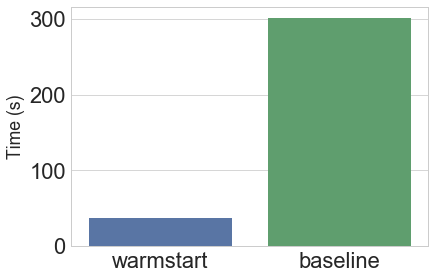

In [30]:
result = pd.DataFrame.from_dict({'method': ['warmstart', 'baseline'], 'time': [sum(optimized), sum(baseline)]})
ax = sns.barplot(x='method', y='time', data=result)
ax.set_ylabel('Time (s)')
ax.set_xlabel('')
ax.tick_params(labelsize=22)
# ax.set_title('Pipeline 8568 (Decision Tree), \nEvery Configuration (555 execution)')
plt.savefig('figures/paper/warmstarting-rf-8568-time.eps', format='eps', dpi=1000, bbox_inches='tight')

